In [86]:
import pandas as pd
from datetime import datetime, timedelta

import math

import json as json
from pandas.io.json import json_normalize

import numpy as np
import os
import scipy.optimize as sco

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [87]:
array_dataframe = []
dados = pd.DataFrame([])
scoins = []

folder_candle = 'Operacoes'

for folder in os.scandir(folder_candle):
    scoins.append(folder.name)
    for entry in os.scandir(folder):
        if entry.is_file():
            coin_symbol = (os.path.splitext(entry.name)[0])        
            with open(entry.path) as d:            
                coin_hist = json.load(d);
            df = json_normalize(coin_hist);
            
            if not df.empty:
            
                df['coin'] = folder.name
                df['amount'] = pd.to_numeric(df['amount'].replace('.',','))
                df['rate'] = pd.to_numeric(df['rate'].replace('.',','))
                df['total'] = pd.to_numeric(df['total'].replace('.',','))
                df['date'] = pd.to_datetime(df['date'])            
                df['day'] = pd.to_datetime(df['date'])
                #df['day'] = pd.to_datetime(df['date'],format='%Y-%m-%d').dt.date
                
                array_dataframe.append(df)       
            else:
                print(entry.path)

dados = pd.concat(array_dataframe)

dados = dados.replace([np.inf, -np.inf], np.nan)
dados = dados.fillna(0)

dados.set_index('date', inplace=True)
dados.index = pd.to_datetime(dados.index)

dados.head()

Operacoes/USDT_BTC/2018-11.json
Operacoes/USDT_BTC/2018-12.json
Operacoes/USDT_ETH/2018-11.json
Operacoes/USDT_ETH/2018-12.json
Operacoes/USDT_LTC/2018-11.json
Operacoes/USDT_LTC/2018-12.json
Operacoes/USDT_ZEC/2018-11.json
Operacoes/USDT_ZEC/2018-12.json


,amount,globalTradeID,rate,total,tradeID,type,coin,day
date,,,,,,,,
2016-05-31 02:51:39,0.092888,33336591,532.409104,49.454294,318883,sell,USDT_BTC,2016-05-31 02:51:39
2016-05-31 02:51:39,0.045243,33336590,532.409104,24.087647,318882,sell,USDT_BTC,2016-05-31 02:51:39
2016-05-31 02:49:20,2.241944,33336506,536.500000,1202.802709,318881,buy,USDT_BTC,2016-05-31 02:49:20
2016-05-31 02:48:38,0.026000,33336465,535.000000,13.910000,318880,buy,USDT_BTC,2016-05-31 02:48:38
2016-05-31 02:46:08,0.000100,33336324,532.210385,0.053221,318879,sell,USDT_BTC,2016-05-31 02:46:08


In [88]:
#Calcula a primeira data e a primeira janela de 24h

#data_inicial = dados.index.min()
data_inicial = pd.to_datetime('2015-08-01')
print(data_inicial)

#Calcula data final da primeira janela
#data_final = data_inicial + timedelta(days=1)
#data_final = data_inicial + timedelta(hours=8)
data_final = data_inicial + timedelta(hours=4)
print(data_final)

#Filtro para a janela
#mask_janela = (dados.index > data_inicial) & (dados.index <= data_final)

#Moeda base
moeda_base = 'USDT_BTC'

#Quantidade de ordens a serem avaliadas no head do book
qtd_relevante_head_book = 0.05 #5%
stop_inicial = 0.10 #10%

operacoes = []
minimo_analise = 5

id_operacoes = 0

#maior_data = dados.day.max() + timedelta(days=1)
#maior_data = dados.day.max() + timedelta(hours=8)
maior_data = dados.day.max() + timedelta(hours=4)

2015-08-01 00:00:00
2015-08-01 04:00:00


In [97]:
def obtem_janela(dt_inicial, dt_final):
    return dados.loc[(dados.index > dt_inicial) & (dados.index <= dt_final)].sort_index(ascending=False)    

In [98]:
janela = obtem_janela(data_inicial,data_final)
janela.head(10)

,amount,globalTradeID,rate,total,tradeID,type,coin,day
date,,,,,,,,
2015-08-08 07:26:52,0.046497,9398982,273.879113,12.734645,19701,sell,USDT_BTC,2015-08-08 07:26:52
2015-08-08 07:26:52,6.869852,9398983,1.850000,12.709227,13,buy,USDT_ETH,2015-08-08 07:26:52
2015-08-08 07:18:38,0.016385,9398887,0.500000,0.008193,12,sell,USDT_ETH,2015-08-08 07:18:38
2015-08-08 07:16:15,0.075639,9398844,273.874325,20.715501,19700,sell,USDT_BTC,2015-08-08 07:16:15
2015-08-08 07:16:15,11.813802,9398845,1.750000,20.674153,11,buy,USDT_ETH,2015-08-08 07:16:15
2015-08-08 07:11:56,0.186198,9398751,1.750000,0.325847,10,buy,USDT_ETH,2015-08-08 07:11:56
2015-08-08 07:11:55,0.001192,9398750,273.952246,0.326499,19699,sell,USDT_BTC,2015-08-08 07:11:55
2015-08-08 06:53:13,12.000000,9398123,1.710000,20.520000,9,buy,USDT_ETH,2015-08-08 06:53:13
2015-08-08 06:53:12,0.074998,9398122,274.155050,20.561039,19698,sell,USDT_BTC,2015-08-08 06:53:12


In [99]:
def calcula_qtd_relevante(dt):
    relevante = dt.coin.count() * qtd_relevante_head_book
    
    if relevante < minimo_analise:
        return minimo_analise
    
    return math.ceil(relevante)

def gera_id_operacao():
    global id_operacoes 
    id_operacoes = id_operacoes + 1
    return id_operacoes;

In [100]:
def avalia_moeda_base(dt):
    coin_result = dt[dt.coin == moeda_base]
    relevante = calcula_qtd_relevante(coin_result)
    
    if not coin_result.empty  :
        dt_sell = coin_result[coin_result.type == 'sell']
        dt_buy  = coin_result[coin_result.type == 'buy']
    
        #Verifica se a moeda base está em queda (sell > buy)
        if dt_sell.amount.sum() > dt_buy.amount.sum() :
            return True
    
    return False


def avalia_compra(dt):
    
    ## Verifica se a moeda base está no momento de compra
    if avalia_moeda_base(dt):
        
        for c in dt.coin.unique():
            coin_result = dt[dt.coin == c]
            
            relevante = calcula_qtd_relevante(coin_result)            
            
            coin_result = coin_result.head(relevante)
            
            if not coin_result.empty  :
                dt_sell = coin_result[coin_result.type == 'sell']
                dt_buy  = coin_result[coin_result.type == 'buy']
    
                #Verifica se a moeda base está em queda (sell > buy)
                if dt_buy.amount.sum() > dt_sell.amount.sum():
                    return True
    
    return False

In [104]:
def define_stop(dt):
    #print('Rate: '+ str(dt.rate))
    #print('10% Rate: '+ str((dt.rate * stop_inicial)))
    return dt.rate + (dt.rate * stop_inicial)

def simula_compra(dt):
    for c in dt[dt.coin != moeda_base].coin.unique() :        
        dt_moeda = dt[dt.coin == c]
        operacao_compra = dt[dt.coin == c].max()
        operacao_compra['id_operacao'] = gera_id_operacao()
        operacao_compra.type = 'buy'
        operacao_compra['closed'] = False
        operacao_compra['stop_update'] = 0
        operacao_compra['stop'] = define_stop(operacao_compra)
        operacoes.append(operacao_compra)

In [105]:
def simula_venda(book_sell, operacao_buy):        
    operacao_venda = book_sell[book_sell.coin == operacao_buy.coin].max()
    
    operacao_venda.type = 'sell'
    operacao_venda['id_operacao'] = operacao_buy.id_operacao
    operacao_buy['closed'] = True
    operacao_venda['closed'] = True
    operacoes.append(operacao_venda)
    
def estrategia(book):
    if not pd.DataFrame(operacoes).empty:
        
        for operacao_buy in operacoes:
            if (operacao_buy.type == 'buy') & (not operacao_buy.closed):
                coin_result = book[book.coin == operacao_buy.coin]               
                
                if not coin_result.empty  :
                    dt_buy = coin_result[coin_result.type == 'buy']
                    dt_buy = dt_buy[dt_buy.day > operacao_buy.day]
                    
                    relevante = calcula_qtd_relevante(dt_buy)
                    
                    dt_buy = dt_buy.head(relevante)
    
                    #Verifica se a moeda base está em queda (sell > buy)
                    if dt_buy.rate.max() <= operacao_buy.stop:
                        simula_venda(dt_buy, operacao_buy)
                    else:
                        atualiza_stop(operacao_buy, coin_result)

def atualiza_stop(operacao,book):
    buy_book = book[book.type == 'buy']
    
    last_order_price = buy_book[buy_book.coin == operacao.coin].mean()
    if not buy_book.empty:
        operacao.stop_update = operacao.stop_update + 1
        operacao.stop = define_stop(last_order_price)

In [106]:
#RESET
operacoes = []
data_inicial = pd.to_datetime('2015-08-01')
#data_final = data_inicial + timedelta(days=1)
#data_final = data_inicial + timedelta(hours=8)
data_final = data_inicial + timedelta(hours=4)

#Coleta a Janela
janela = obtem_janela(data_inicial,data_final)

while not data_final > maior_data :
    if not janela.empty :
        
        if avalia_compra(janela):
            simula_compra(janela)
    
        estrategia(janela)                
    
    data_inicial = data_final
    #data_final = data_inicial + timedelta(days=1)    
    #data_final = data_inicial + timedelta(hours=8)
    data_final = data_inicial + timedelta(hours=4)
    print('De: '+ str(data_inicial) + 'Até: '+ str(data_final))
    janela = obtem_janela(data_inicial,data_final)   

De: 2015-08-01 04:00:00Até: 2015-08-01 08:00:00
De: 2015-08-01 08:00:00Até: 2015-08-01 12:00:00
De: 2015-08-01 12:00:00Até: 2015-08-01 16:00:00
De: 2015-08-01 16:00:00Até: 2015-08-01 20:00:00
De: 2015-08-01 20:00:00Até: 2015-08-02 00:00:00
De: 2015-08-02 00:00:00Até: 2015-08-02 04:00:00
De: 2015-08-02 04:00:00Até: 2015-08-02 08:00:00
De: 2015-08-02 08:00:00Até: 2015-08-02 12:00:00
De: 2015-08-02 12:00:00Até: 2015-08-02 16:00:00
De: 2015-08-02 16:00:00Até: 2015-08-02 20:00:00
De: 2015-08-02 20:00:00Até: 2015-08-03 00:00:00
De: 2015-08-03 00:00:00Até: 2015-08-03 04:00:00
De: 2015-08-03 04:00:00Até: 2015-08-03 08:00:00
De: 2015-08-03 08:00:00Até: 2015-08-03 12:00:00
De: 2015-08-03 12:00:00Até: 2015-08-03 16:00:00
De: 2015-08-03 16:00:00Até: 2015-08-03 20:00:00
De: 2015-08-03 20:00:00Até: 2015-08-04 00:00:00
De: 2015-08-04 00:00:00Até: 2015-08-04 04:00:00
De: 2015-08-04 04:00:00Até: 2015-08-04 08:00:00
De: 2015-08-04 08:00:00Até: 2015-08-04 12:00:00
De: 2015-08-04 12:00:00Até: 2015-08-04 1

De: 2015-08-30 08:00:00Até: 2015-08-30 12:00:00
De: 2015-08-30 12:00:00Até: 2015-08-30 16:00:00
De: 2015-08-30 16:00:00Até: 2015-08-30 20:00:00
De: 2015-08-30 20:00:00Até: 2015-08-31 00:00:00
De: 2015-08-31 00:00:00Até: 2015-08-31 04:00:00
De: 2015-08-31 04:00:00Até: 2015-08-31 08:00:00
De: 2015-08-31 08:00:00Até: 2015-08-31 12:00:00
De: 2015-08-31 12:00:00Até: 2015-08-31 16:00:00
De: 2015-08-31 16:00:00Até: 2015-08-31 20:00:00
De: 2015-08-31 20:00:00Até: 2015-09-01 00:00:00
De: 2015-09-01 00:00:00Até: 2015-09-01 04:00:00
De: 2015-09-01 04:00:00Até: 2015-09-01 08:00:00
De: 2015-09-01 08:00:00Até: 2015-09-01 12:00:00
De: 2015-09-01 12:00:00Até: 2015-09-01 16:00:00
De: 2015-09-01 16:00:00Até: 2015-09-01 20:00:00
De: 2015-09-01 20:00:00Até: 2015-09-02 00:00:00
De: 2015-09-02 00:00:00Até: 2015-09-02 04:00:00
De: 2015-09-02 04:00:00Até: 2015-09-02 08:00:00
De: 2015-09-02 08:00:00Até: 2015-09-02 12:00:00
De: 2015-09-02 12:00:00Até: 2015-09-02 16:00:00
De: 2015-09-02 16:00:00Até: 2015-09-02 2

De: 2015-09-27 20:00:00Até: 2015-09-28 00:00:00
De: 2015-09-28 00:00:00Até: 2015-09-28 04:00:00
De: 2015-09-28 04:00:00Até: 2015-09-28 08:00:00
De: 2015-09-28 08:00:00Até: 2015-09-28 12:00:00
De: 2015-09-28 12:00:00Até: 2015-09-28 16:00:00
De: 2015-09-28 16:00:00Até: 2015-09-28 20:00:00
De: 2015-09-28 20:00:00Até: 2015-09-29 00:00:00
De: 2015-09-29 00:00:00Até: 2015-09-29 04:00:00
De: 2015-09-29 04:00:00Até: 2015-09-29 08:00:00
De: 2015-09-29 08:00:00Até: 2015-09-29 12:00:00
De: 2015-09-29 12:00:00Até: 2015-09-29 16:00:00
De: 2015-09-29 16:00:00Até: 2015-09-29 20:00:00
De: 2015-09-29 20:00:00Até: 2015-09-30 00:00:00
De: 2015-09-30 00:00:00Até: 2015-09-30 04:00:00
De: 2015-09-30 04:00:00Até: 2015-09-30 08:00:00
De: 2015-09-30 08:00:00Até: 2015-09-30 12:00:00
De: 2015-09-30 12:00:00Até: 2015-09-30 16:00:00
De: 2015-09-30 16:00:00Até: 2015-09-30 20:00:00
De: 2015-09-30 20:00:00Até: 2015-10-01 00:00:00
De: 2015-10-01 00:00:00Até: 2015-10-01 04:00:00
De: 2015-10-01 04:00:00Até: 2015-10-01 0

De: 2015-10-26 12:00:00Até: 2015-10-26 16:00:00
De: 2015-10-26 16:00:00Até: 2015-10-26 20:00:00
De: 2015-10-26 20:00:00Até: 2015-10-27 00:00:00
De: 2015-10-27 00:00:00Até: 2015-10-27 04:00:00
De: 2015-10-27 04:00:00Até: 2015-10-27 08:00:00
De: 2015-10-27 08:00:00Até: 2015-10-27 12:00:00
De: 2015-10-27 12:00:00Até: 2015-10-27 16:00:00
De: 2015-10-27 16:00:00Até: 2015-10-27 20:00:00
De: 2015-10-27 20:00:00Até: 2015-10-28 00:00:00
De: 2015-10-28 00:00:00Até: 2015-10-28 04:00:00
De: 2015-10-28 04:00:00Até: 2015-10-28 08:00:00
De: 2015-10-28 08:00:00Até: 2015-10-28 12:00:00
De: 2015-10-28 12:00:00Até: 2015-10-28 16:00:00
De: 2015-10-28 16:00:00Até: 2015-10-28 20:00:00
De: 2015-10-28 20:00:00Até: 2015-10-29 00:00:00
De: 2015-10-29 00:00:00Até: 2015-10-29 04:00:00
De: 2015-10-29 04:00:00Até: 2015-10-29 08:00:00
De: 2015-10-29 08:00:00Até: 2015-10-29 12:00:00
De: 2015-10-29 12:00:00Até: 2015-10-29 16:00:00
De: 2015-10-29 16:00:00Até: 2015-10-29 20:00:00
De: 2015-10-29 20:00:00Até: 2015-10-30 0

De: 2015-11-24 12:00:00Até: 2015-11-24 16:00:00
De: 2015-11-24 16:00:00Até: 2015-11-24 20:00:00
De: 2015-11-24 20:00:00Até: 2015-11-25 00:00:00
De: 2015-11-25 00:00:00Até: 2015-11-25 04:00:00
De: 2015-11-25 04:00:00Até: 2015-11-25 08:00:00
De: 2015-11-25 08:00:00Até: 2015-11-25 12:00:00
De: 2015-11-25 12:00:00Até: 2015-11-25 16:00:00
De: 2015-11-25 16:00:00Até: 2015-11-25 20:00:00
De: 2015-11-25 20:00:00Até: 2015-11-26 00:00:00
De: 2015-11-26 00:00:00Até: 2015-11-26 04:00:00
De: 2015-11-26 04:00:00Até: 2015-11-26 08:00:00
De: 2015-11-26 08:00:00Até: 2015-11-26 12:00:00
De: 2015-11-26 12:00:00Até: 2015-11-26 16:00:00
De: 2015-11-26 16:00:00Até: 2015-11-26 20:00:00
De: 2015-11-26 20:00:00Até: 2015-11-27 00:00:00
De: 2015-11-27 00:00:00Até: 2015-11-27 04:00:00
De: 2015-11-27 04:00:00Até: 2015-11-27 08:00:00
De: 2015-11-27 08:00:00Até: 2015-11-27 12:00:00
De: 2015-11-27 12:00:00Até: 2015-11-27 16:00:00
De: 2015-11-27 16:00:00Até: 2015-11-27 20:00:00
De: 2015-11-27 20:00:00Até: 2015-11-28 0

De: 2015-12-23 08:00:00Até: 2015-12-23 12:00:00
De: 2015-12-23 12:00:00Até: 2015-12-23 16:00:00
De: 2015-12-23 16:00:00Até: 2015-12-23 20:00:00
De: 2015-12-23 20:00:00Até: 2015-12-24 00:00:00
De: 2015-12-24 00:00:00Até: 2015-12-24 04:00:00
De: 2015-12-24 04:00:00Até: 2015-12-24 08:00:00
De: 2015-12-24 08:00:00Até: 2015-12-24 12:00:00
De: 2015-12-24 12:00:00Até: 2015-12-24 16:00:00
De: 2015-12-24 16:00:00Até: 2015-12-24 20:00:00
De: 2015-12-24 20:00:00Até: 2015-12-25 00:00:00
De: 2015-12-25 00:00:00Até: 2015-12-25 04:00:00
De: 2015-12-25 04:00:00Até: 2015-12-25 08:00:00
De: 2015-12-25 08:00:00Até: 2015-12-25 12:00:00
De: 2015-12-25 12:00:00Até: 2015-12-25 16:00:00
De: 2015-12-25 16:00:00Até: 2015-12-25 20:00:00
De: 2015-12-25 20:00:00Até: 2015-12-26 00:00:00
De: 2015-12-26 00:00:00Até: 2015-12-26 04:00:00
De: 2015-12-26 04:00:00Até: 2015-12-26 08:00:00
De: 2015-12-26 08:00:00Até: 2015-12-26 12:00:00
De: 2015-12-26 12:00:00Até: 2015-12-26 16:00:00
De: 2015-12-26 16:00:00Até: 2015-12-26 2

De: 2016-01-21 00:00:00Até: 2016-01-21 04:00:00
De: 2016-01-21 04:00:00Até: 2016-01-21 08:00:00
De: 2016-01-21 08:00:00Até: 2016-01-21 12:00:00
De: 2016-01-21 12:00:00Até: 2016-01-21 16:00:00
De: 2016-01-21 16:00:00Até: 2016-01-21 20:00:00
De: 2016-01-21 20:00:00Até: 2016-01-22 00:00:00
De: 2016-01-22 00:00:00Até: 2016-01-22 04:00:00
De: 2016-01-22 04:00:00Até: 2016-01-22 08:00:00
De: 2016-01-22 08:00:00Até: 2016-01-22 12:00:00
De: 2016-01-22 12:00:00Até: 2016-01-22 16:00:00
De: 2016-01-22 16:00:00Até: 2016-01-22 20:00:00
De: 2016-01-22 20:00:00Até: 2016-01-23 00:00:00
De: 2016-01-23 00:00:00Até: 2016-01-23 04:00:00
De: 2016-01-23 04:00:00Até: 2016-01-23 08:00:00
De: 2016-01-23 08:00:00Até: 2016-01-23 12:00:00
De: 2016-01-23 12:00:00Até: 2016-01-23 16:00:00
De: 2016-01-23 16:00:00Até: 2016-01-23 20:00:00
De: 2016-01-23 20:00:00Até: 2016-01-24 00:00:00
De: 2016-01-24 00:00:00Até: 2016-01-24 04:00:00
De: 2016-01-24 04:00:00Até: 2016-01-24 08:00:00
De: 2016-01-24 08:00:00Até: 2016-01-24 1

De: 2016-02-18 16:00:00Até: 2016-02-18 20:00:00
De: 2016-02-18 20:00:00Até: 2016-02-19 00:00:00
De: 2016-02-19 00:00:00Até: 2016-02-19 04:00:00
De: 2016-02-19 04:00:00Até: 2016-02-19 08:00:00
De: 2016-02-19 08:00:00Até: 2016-02-19 12:00:00
De: 2016-02-19 12:00:00Até: 2016-02-19 16:00:00
De: 2016-02-19 16:00:00Até: 2016-02-19 20:00:00
De: 2016-02-19 20:00:00Até: 2016-02-20 00:00:00
De: 2016-02-20 00:00:00Até: 2016-02-20 04:00:00
De: 2016-02-20 04:00:00Até: 2016-02-20 08:00:00
De: 2016-02-20 08:00:00Até: 2016-02-20 12:00:00
De: 2016-02-20 12:00:00Até: 2016-02-20 16:00:00
De: 2016-02-20 16:00:00Até: 2016-02-20 20:00:00
De: 2016-02-20 20:00:00Até: 2016-02-21 00:00:00
De: 2016-02-21 00:00:00Até: 2016-02-21 04:00:00
De: 2016-02-21 04:00:00Até: 2016-02-21 08:00:00
De: 2016-02-21 08:00:00Até: 2016-02-21 12:00:00
De: 2016-02-21 12:00:00Até: 2016-02-21 16:00:00
De: 2016-02-21 16:00:00Até: 2016-02-21 20:00:00
De: 2016-02-21 20:00:00Até: 2016-02-22 00:00:00
De: 2016-02-22 00:00:00Até: 2016-02-22 0

De: 2016-03-18 04:00:00Até: 2016-03-18 08:00:00
De: 2016-03-18 08:00:00Até: 2016-03-18 12:00:00
De: 2016-03-18 12:00:00Até: 2016-03-18 16:00:00
De: 2016-03-18 16:00:00Até: 2016-03-18 20:00:00
De: 2016-03-18 20:00:00Até: 2016-03-19 00:00:00
De: 2016-03-19 00:00:00Até: 2016-03-19 04:00:00
De: 2016-03-19 04:00:00Até: 2016-03-19 08:00:00
De: 2016-03-19 08:00:00Até: 2016-03-19 12:00:00
De: 2016-03-19 12:00:00Até: 2016-03-19 16:00:00
De: 2016-03-19 16:00:00Até: 2016-03-19 20:00:00
De: 2016-03-19 20:00:00Até: 2016-03-20 00:00:00
De: 2016-03-20 00:00:00Até: 2016-03-20 04:00:00
De: 2016-03-20 04:00:00Até: 2016-03-20 08:00:00
De: 2016-03-20 08:00:00Até: 2016-03-20 12:00:00
De: 2016-03-20 12:00:00Até: 2016-03-20 16:00:00
De: 2016-03-20 16:00:00Até: 2016-03-20 20:00:00
De: 2016-03-20 20:00:00Até: 2016-03-21 00:00:00
De: 2016-03-21 00:00:00Até: 2016-03-21 04:00:00
De: 2016-03-21 04:00:00Até: 2016-03-21 08:00:00
De: 2016-03-21 08:00:00Até: 2016-03-21 12:00:00
De: 2016-03-21 12:00:00Até: 2016-03-21 1

De: 2016-04-15 20:00:00Até: 2016-04-16 00:00:00
De: 2016-04-16 00:00:00Até: 2016-04-16 04:00:00
De: 2016-04-16 04:00:00Até: 2016-04-16 08:00:00
De: 2016-04-16 08:00:00Até: 2016-04-16 12:00:00
De: 2016-04-16 12:00:00Até: 2016-04-16 16:00:00
De: 2016-04-16 16:00:00Até: 2016-04-16 20:00:00
De: 2016-04-16 20:00:00Até: 2016-04-17 00:00:00
De: 2016-04-17 00:00:00Até: 2016-04-17 04:00:00
De: 2016-04-17 04:00:00Até: 2016-04-17 08:00:00
De: 2016-04-17 08:00:00Até: 2016-04-17 12:00:00
De: 2016-04-17 12:00:00Até: 2016-04-17 16:00:00
De: 2016-04-17 16:00:00Até: 2016-04-17 20:00:00
De: 2016-04-17 20:00:00Até: 2016-04-18 00:00:00
De: 2016-04-18 00:00:00Até: 2016-04-18 04:00:00
De: 2016-04-18 04:00:00Até: 2016-04-18 08:00:00
De: 2016-04-18 08:00:00Até: 2016-04-18 12:00:00
De: 2016-04-18 12:00:00Até: 2016-04-18 16:00:00
De: 2016-04-18 16:00:00Até: 2016-04-18 20:00:00
De: 2016-04-18 20:00:00Até: 2016-04-19 00:00:00
De: 2016-04-19 00:00:00Até: 2016-04-19 04:00:00
De: 2016-04-19 04:00:00Até: 2016-04-19 0

De: 2016-05-14 12:00:00Até: 2016-05-14 16:00:00
De: 2016-05-14 16:00:00Até: 2016-05-14 20:00:00
De: 2016-05-14 20:00:00Até: 2016-05-15 00:00:00
De: 2016-05-15 00:00:00Até: 2016-05-15 04:00:00
De: 2016-05-15 04:00:00Até: 2016-05-15 08:00:00
De: 2016-05-15 08:00:00Até: 2016-05-15 12:00:00
De: 2016-05-15 12:00:00Até: 2016-05-15 16:00:00
De: 2016-05-15 16:00:00Até: 2016-05-15 20:00:00
De: 2016-05-15 20:00:00Até: 2016-05-16 00:00:00
De: 2016-05-16 00:00:00Até: 2016-05-16 04:00:00
De: 2016-05-16 04:00:00Até: 2016-05-16 08:00:00
De: 2016-05-16 08:00:00Até: 2016-05-16 12:00:00
De: 2016-05-16 12:00:00Até: 2016-05-16 16:00:00
De: 2016-05-16 16:00:00Até: 2016-05-16 20:00:00
De: 2016-05-16 20:00:00Até: 2016-05-17 00:00:00
De: 2016-05-17 00:00:00Até: 2016-05-17 04:00:00
De: 2016-05-17 04:00:00Até: 2016-05-17 08:00:00
De: 2016-05-17 08:00:00Até: 2016-05-17 12:00:00
De: 2016-05-17 12:00:00Até: 2016-05-17 16:00:00
De: 2016-05-17 16:00:00Até: 2016-05-17 20:00:00
De: 2016-05-17 20:00:00Até: 2016-05-18 0

De: 2016-06-12 04:00:00Até: 2016-06-12 08:00:00
De: 2016-06-12 08:00:00Até: 2016-06-12 12:00:00
De: 2016-06-12 12:00:00Até: 2016-06-12 16:00:00
De: 2016-06-12 16:00:00Até: 2016-06-12 20:00:00
De: 2016-06-12 20:00:00Até: 2016-06-13 00:00:00
De: 2016-06-13 00:00:00Até: 2016-06-13 04:00:00
De: 2016-06-13 04:00:00Até: 2016-06-13 08:00:00
De: 2016-06-13 08:00:00Até: 2016-06-13 12:00:00
De: 2016-06-13 12:00:00Até: 2016-06-13 16:00:00
De: 2016-06-13 16:00:00Até: 2016-06-13 20:00:00
De: 2016-06-13 20:00:00Até: 2016-06-14 00:00:00
De: 2016-06-14 00:00:00Até: 2016-06-14 04:00:00
De: 2016-06-14 04:00:00Até: 2016-06-14 08:00:00
De: 2016-06-14 08:00:00Até: 2016-06-14 12:00:00
De: 2016-06-14 12:00:00Até: 2016-06-14 16:00:00
De: 2016-06-14 16:00:00Até: 2016-06-14 20:00:00
De: 2016-06-14 20:00:00Até: 2016-06-15 00:00:00
De: 2016-06-15 00:00:00Até: 2016-06-15 04:00:00
De: 2016-06-15 04:00:00Até: 2016-06-15 08:00:00
De: 2016-06-15 08:00:00Até: 2016-06-15 12:00:00
De: 2016-06-15 12:00:00Até: 2016-06-15 1

De: 2016-07-10 16:00:00Até: 2016-07-10 20:00:00
De: 2016-07-10 20:00:00Até: 2016-07-11 00:00:00
De: 2016-07-11 00:00:00Até: 2016-07-11 04:00:00
De: 2016-07-11 04:00:00Até: 2016-07-11 08:00:00
De: 2016-07-11 08:00:00Até: 2016-07-11 12:00:00
De: 2016-07-11 12:00:00Até: 2016-07-11 16:00:00
De: 2016-07-11 16:00:00Até: 2016-07-11 20:00:00
De: 2016-07-11 20:00:00Até: 2016-07-12 00:00:00
De: 2016-07-12 00:00:00Até: 2016-07-12 04:00:00
De: 2016-07-12 04:00:00Até: 2016-07-12 08:00:00
De: 2016-07-12 08:00:00Até: 2016-07-12 12:00:00
De: 2016-07-12 12:00:00Até: 2016-07-12 16:00:00
De: 2016-07-12 16:00:00Até: 2016-07-12 20:00:00
De: 2016-07-12 20:00:00Até: 2016-07-13 00:00:00
De: 2016-07-13 00:00:00Até: 2016-07-13 04:00:00
De: 2016-07-13 04:00:00Até: 2016-07-13 08:00:00
De: 2016-07-13 08:00:00Até: 2016-07-13 12:00:00
De: 2016-07-13 12:00:00Até: 2016-07-13 16:00:00
De: 2016-07-13 16:00:00Até: 2016-07-13 20:00:00
De: 2016-07-13 20:00:00Até: 2016-07-14 00:00:00
De: 2016-07-14 00:00:00Até: 2016-07-14 0

De: 2016-08-08 08:00:00Até: 2016-08-08 12:00:00
De: 2016-08-08 12:00:00Até: 2016-08-08 16:00:00
De: 2016-08-08 16:00:00Até: 2016-08-08 20:00:00
De: 2016-08-08 20:00:00Até: 2016-08-09 00:00:00
De: 2016-08-09 00:00:00Até: 2016-08-09 04:00:00
De: 2016-08-09 04:00:00Até: 2016-08-09 08:00:00
De: 2016-08-09 08:00:00Até: 2016-08-09 12:00:00
De: 2016-08-09 12:00:00Até: 2016-08-09 16:00:00
De: 2016-08-09 16:00:00Até: 2016-08-09 20:00:00
De: 2016-08-09 20:00:00Até: 2016-08-10 00:00:00
De: 2016-08-10 00:00:00Até: 2016-08-10 04:00:00
De: 2016-08-10 04:00:00Até: 2016-08-10 08:00:00
De: 2016-08-10 08:00:00Até: 2016-08-10 12:00:00
De: 2016-08-10 12:00:00Até: 2016-08-10 16:00:00
De: 2016-08-10 16:00:00Até: 2016-08-10 20:00:00
De: 2016-08-10 20:00:00Até: 2016-08-11 00:00:00
De: 2016-08-11 00:00:00Até: 2016-08-11 04:00:00
De: 2016-08-11 04:00:00Até: 2016-08-11 08:00:00
De: 2016-08-11 08:00:00Até: 2016-08-11 12:00:00
De: 2016-08-11 12:00:00Até: 2016-08-11 16:00:00
De: 2016-08-11 16:00:00Até: 2016-08-11 2

De: 2016-09-05 20:00:00Até: 2016-09-06 00:00:00
De: 2016-09-06 00:00:00Até: 2016-09-06 04:00:00
De: 2016-09-06 04:00:00Até: 2016-09-06 08:00:00
De: 2016-09-06 08:00:00Até: 2016-09-06 12:00:00
De: 2016-09-06 12:00:00Até: 2016-09-06 16:00:00
De: 2016-09-06 16:00:00Até: 2016-09-06 20:00:00
De: 2016-09-06 20:00:00Até: 2016-09-07 00:00:00
De: 2016-09-07 00:00:00Até: 2016-09-07 04:00:00
De: 2016-09-07 04:00:00Até: 2016-09-07 08:00:00
De: 2016-09-07 08:00:00Até: 2016-09-07 12:00:00
De: 2016-09-07 12:00:00Até: 2016-09-07 16:00:00
De: 2016-09-07 16:00:00Até: 2016-09-07 20:00:00
De: 2016-09-07 20:00:00Até: 2016-09-08 00:00:00
De: 2016-09-08 00:00:00Até: 2016-09-08 04:00:00
De: 2016-09-08 04:00:00Até: 2016-09-08 08:00:00
De: 2016-09-08 08:00:00Até: 2016-09-08 12:00:00
De: 2016-09-08 12:00:00Até: 2016-09-08 16:00:00
De: 2016-09-08 16:00:00Até: 2016-09-08 20:00:00
De: 2016-09-08 20:00:00Até: 2016-09-09 00:00:00
De: 2016-09-09 00:00:00Até: 2016-09-09 04:00:00
De: 2016-09-09 04:00:00Até: 2016-09-09 0

De: 2016-10-04 08:00:00Até: 2016-10-04 12:00:00
De: 2016-10-04 12:00:00Até: 2016-10-04 16:00:00
De: 2016-10-04 16:00:00Até: 2016-10-04 20:00:00
De: 2016-10-04 20:00:00Até: 2016-10-05 00:00:00
De: 2016-10-05 00:00:00Até: 2016-10-05 04:00:00
De: 2016-10-05 04:00:00Até: 2016-10-05 08:00:00
De: 2016-10-05 08:00:00Até: 2016-10-05 12:00:00
De: 2016-10-05 12:00:00Até: 2016-10-05 16:00:00
De: 2016-10-05 16:00:00Até: 2016-10-05 20:00:00
De: 2016-10-05 20:00:00Até: 2016-10-06 00:00:00
De: 2016-10-06 00:00:00Até: 2016-10-06 04:00:00
De: 2016-10-06 04:00:00Até: 2016-10-06 08:00:00
De: 2016-10-06 08:00:00Até: 2016-10-06 12:00:00
De: 2016-10-06 12:00:00Até: 2016-10-06 16:00:00
De: 2016-10-06 16:00:00Até: 2016-10-06 20:00:00
De: 2016-10-06 20:00:00Até: 2016-10-07 00:00:00
De: 2016-10-07 00:00:00Até: 2016-10-07 04:00:00
De: 2016-10-07 04:00:00Até: 2016-10-07 08:00:00
De: 2016-10-07 08:00:00Até: 2016-10-07 12:00:00
De: 2016-10-07 12:00:00Até: 2016-10-07 16:00:00
De: 2016-10-07 16:00:00Até: 2016-10-07 2

De: 2016-11-01 20:00:00Até: 2016-11-02 00:00:00
De: 2016-11-02 00:00:00Até: 2016-11-02 04:00:00
De: 2016-11-02 04:00:00Até: 2016-11-02 08:00:00
De: 2016-11-02 08:00:00Até: 2016-11-02 12:00:00
De: 2016-11-02 12:00:00Até: 2016-11-02 16:00:00
De: 2016-11-02 16:00:00Até: 2016-11-02 20:00:00
De: 2016-11-02 20:00:00Até: 2016-11-03 00:00:00
De: 2016-11-03 00:00:00Até: 2016-11-03 04:00:00
De: 2016-11-03 04:00:00Até: 2016-11-03 08:00:00
De: 2016-11-03 08:00:00Até: 2016-11-03 12:00:00
De: 2016-11-03 12:00:00Até: 2016-11-03 16:00:00
De: 2016-11-03 16:00:00Até: 2016-11-03 20:00:00
De: 2016-11-03 20:00:00Até: 2016-11-04 00:00:00
De: 2016-11-04 00:00:00Até: 2016-11-04 04:00:00
De: 2016-11-04 04:00:00Até: 2016-11-04 08:00:00
De: 2016-11-04 08:00:00Até: 2016-11-04 12:00:00
De: 2016-11-04 12:00:00Até: 2016-11-04 16:00:00
De: 2016-11-04 16:00:00Até: 2016-11-04 20:00:00
De: 2016-11-04 20:00:00Até: 2016-11-05 00:00:00
De: 2016-11-05 00:00:00Até: 2016-11-05 04:00:00
De: 2016-11-05 04:00:00Até: 2016-11-05 0

De: 2016-12-01 04:00:00Até: 2016-12-01 08:00:00
De: 2016-12-01 08:00:00Até: 2016-12-01 12:00:00
De: 2016-12-01 12:00:00Até: 2016-12-01 16:00:00
De: 2016-12-01 16:00:00Até: 2016-12-01 20:00:00
De: 2016-12-01 20:00:00Até: 2016-12-02 00:00:00
De: 2016-12-02 00:00:00Até: 2016-12-02 04:00:00
De: 2016-12-02 04:00:00Até: 2016-12-02 08:00:00
De: 2016-12-02 08:00:00Até: 2016-12-02 12:00:00
De: 2016-12-02 12:00:00Até: 2016-12-02 16:00:00
De: 2016-12-02 16:00:00Até: 2016-12-02 20:00:00
De: 2016-12-02 20:00:00Até: 2016-12-03 00:00:00
De: 2016-12-03 00:00:00Até: 2016-12-03 04:00:00
De: 2016-12-03 04:00:00Até: 2016-12-03 08:00:00
De: 2016-12-03 08:00:00Até: 2016-12-03 12:00:00
De: 2016-12-03 12:00:00Até: 2016-12-03 16:00:00
De: 2016-12-03 16:00:00Até: 2016-12-03 20:00:00
De: 2016-12-03 20:00:00Até: 2016-12-04 00:00:00
De: 2016-12-04 00:00:00Até: 2016-12-04 04:00:00
De: 2016-12-04 04:00:00Até: 2016-12-04 08:00:00
De: 2016-12-04 08:00:00Até: 2016-12-04 12:00:00
De: 2016-12-04 12:00:00Até: 2016-12-04 1

De: 2016-12-29 16:00:00Até: 2016-12-29 20:00:00
De: 2016-12-29 20:00:00Até: 2016-12-30 00:00:00
De: 2016-12-30 00:00:00Até: 2016-12-30 04:00:00
De: 2016-12-30 04:00:00Até: 2016-12-30 08:00:00
De: 2016-12-30 08:00:00Até: 2016-12-30 12:00:00
De: 2016-12-30 12:00:00Até: 2016-12-30 16:00:00
De: 2016-12-30 16:00:00Até: 2016-12-30 20:00:00
De: 2016-12-30 20:00:00Até: 2016-12-31 00:00:00
De: 2016-12-31 00:00:00Até: 2016-12-31 04:00:00
De: 2016-12-31 04:00:00Até: 2016-12-31 08:00:00
De: 2016-12-31 08:00:00Até: 2016-12-31 12:00:00
De: 2016-12-31 12:00:00Até: 2016-12-31 16:00:00
De: 2016-12-31 16:00:00Até: 2016-12-31 20:00:00
De: 2016-12-31 20:00:00Até: 2017-01-01 00:00:00
De: 2017-01-01 00:00:00Até: 2017-01-01 04:00:00
De: 2017-01-01 04:00:00Até: 2017-01-01 08:00:00
De: 2017-01-01 08:00:00Até: 2017-01-01 12:00:00
De: 2017-01-01 12:00:00Até: 2017-01-01 16:00:00
De: 2017-01-01 16:00:00Até: 2017-01-01 20:00:00
De: 2017-01-01 20:00:00Até: 2017-01-02 00:00:00
De: 2017-01-02 00:00:00Até: 2017-01-02 0

De: 2017-01-27 04:00:00Até: 2017-01-27 08:00:00
De: 2017-01-27 08:00:00Até: 2017-01-27 12:00:00
De: 2017-01-27 12:00:00Até: 2017-01-27 16:00:00
De: 2017-01-27 16:00:00Até: 2017-01-27 20:00:00
De: 2017-01-27 20:00:00Até: 2017-01-28 00:00:00
De: 2017-01-28 00:00:00Até: 2017-01-28 04:00:00
De: 2017-01-28 04:00:00Até: 2017-01-28 08:00:00
De: 2017-01-28 08:00:00Até: 2017-01-28 12:00:00
De: 2017-01-28 12:00:00Até: 2017-01-28 16:00:00
De: 2017-01-28 16:00:00Até: 2017-01-28 20:00:00
De: 2017-01-28 20:00:00Até: 2017-01-29 00:00:00
De: 2017-01-29 00:00:00Até: 2017-01-29 04:00:00
De: 2017-01-29 04:00:00Até: 2017-01-29 08:00:00
De: 2017-01-29 08:00:00Até: 2017-01-29 12:00:00
De: 2017-01-29 12:00:00Até: 2017-01-29 16:00:00
De: 2017-01-29 16:00:00Até: 2017-01-29 20:00:00
De: 2017-01-29 20:00:00Até: 2017-01-30 00:00:00
De: 2017-01-30 00:00:00Até: 2017-01-30 04:00:00
De: 2017-01-30 04:00:00Até: 2017-01-30 08:00:00
De: 2017-01-30 08:00:00Até: 2017-01-30 12:00:00
De: 2017-01-30 12:00:00Até: 2017-01-30 1

De: 2017-02-24 16:00:00Até: 2017-02-24 20:00:00
De: 2017-02-24 20:00:00Até: 2017-02-25 00:00:00
De: 2017-02-25 00:00:00Até: 2017-02-25 04:00:00
De: 2017-02-25 04:00:00Até: 2017-02-25 08:00:00
De: 2017-02-25 08:00:00Até: 2017-02-25 12:00:00
De: 2017-02-25 12:00:00Até: 2017-02-25 16:00:00
De: 2017-02-25 16:00:00Até: 2017-02-25 20:00:00
De: 2017-02-25 20:00:00Até: 2017-02-26 00:00:00
De: 2017-02-26 00:00:00Até: 2017-02-26 04:00:00
De: 2017-02-26 04:00:00Até: 2017-02-26 08:00:00
De: 2017-02-26 08:00:00Até: 2017-02-26 12:00:00
De: 2017-02-26 12:00:00Até: 2017-02-26 16:00:00
De: 2017-02-26 16:00:00Até: 2017-02-26 20:00:00
De: 2017-02-26 20:00:00Até: 2017-02-27 00:00:00
De: 2017-02-27 00:00:00Até: 2017-02-27 04:00:00
De: 2017-02-27 04:00:00Até: 2017-02-27 08:00:00
De: 2017-02-27 08:00:00Até: 2017-02-27 12:00:00
De: 2017-02-27 12:00:00Até: 2017-02-27 16:00:00
De: 2017-02-27 16:00:00Até: 2017-02-27 20:00:00
De: 2017-02-27 20:00:00Até: 2017-02-28 00:00:00
De: 2017-02-28 00:00:00Até: 2017-02-28 0

De: 2017-03-25 04:00:00Até: 2017-03-25 08:00:00
De: 2017-03-25 08:00:00Até: 2017-03-25 12:00:00
De: 2017-03-25 12:00:00Até: 2017-03-25 16:00:00
De: 2017-03-25 16:00:00Até: 2017-03-25 20:00:00
De: 2017-03-25 20:00:00Até: 2017-03-26 00:00:00
De: 2017-03-26 00:00:00Até: 2017-03-26 04:00:00
De: 2017-03-26 04:00:00Até: 2017-03-26 08:00:00
De: 2017-03-26 08:00:00Até: 2017-03-26 12:00:00
De: 2017-03-26 12:00:00Até: 2017-03-26 16:00:00
De: 2017-03-26 16:00:00Até: 2017-03-26 20:00:00
De: 2017-03-26 20:00:00Até: 2017-03-27 00:00:00
De: 2017-03-27 00:00:00Até: 2017-03-27 04:00:00
De: 2017-03-27 04:00:00Até: 2017-03-27 08:00:00
De: 2017-03-27 08:00:00Até: 2017-03-27 12:00:00
De: 2017-03-27 12:00:00Até: 2017-03-27 16:00:00
De: 2017-03-27 16:00:00Até: 2017-03-27 20:00:00
De: 2017-03-27 20:00:00Até: 2017-03-28 00:00:00
De: 2017-03-28 00:00:00Até: 2017-03-28 04:00:00
De: 2017-03-28 04:00:00Até: 2017-03-28 08:00:00
De: 2017-03-28 08:00:00Até: 2017-03-28 12:00:00
De: 2017-03-28 12:00:00Até: 2017-03-28 1

De: 2017-04-22 16:00:00Até: 2017-04-22 20:00:00
De: 2017-04-22 20:00:00Até: 2017-04-23 00:00:00
De: 2017-04-23 00:00:00Até: 2017-04-23 04:00:00
De: 2017-04-23 04:00:00Até: 2017-04-23 08:00:00
De: 2017-04-23 08:00:00Até: 2017-04-23 12:00:00
De: 2017-04-23 12:00:00Até: 2017-04-23 16:00:00
De: 2017-04-23 16:00:00Até: 2017-04-23 20:00:00
De: 2017-04-23 20:00:00Até: 2017-04-24 00:00:00
De: 2017-04-24 00:00:00Até: 2017-04-24 04:00:00
De: 2017-04-24 04:00:00Até: 2017-04-24 08:00:00
De: 2017-04-24 08:00:00Até: 2017-04-24 12:00:00
De: 2017-04-24 12:00:00Até: 2017-04-24 16:00:00
De: 2017-04-24 16:00:00Até: 2017-04-24 20:00:00
De: 2017-04-24 20:00:00Até: 2017-04-25 00:00:00
De: 2017-04-25 00:00:00Até: 2017-04-25 04:00:00
De: 2017-04-25 04:00:00Até: 2017-04-25 08:00:00
De: 2017-04-25 08:00:00Até: 2017-04-25 12:00:00
De: 2017-04-25 12:00:00Até: 2017-04-25 16:00:00
De: 2017-04-25 16:00:00Até: 2017-04-25 20:00:00
De: 2017-04-25 20:00:00Até: 2017-04-26 00:00:00
De: 2017-04-26 00:00:00Até: 2017-04-26 0

De: 2017-05-22 00:00:00Até: 2017-05-22 04:00:00
De: 2017-05-22 04:00:00Até: 2017-05-22 08:00:00
De: 2017-05-22 08:00:00Até: 2017-05-22 12:00:00
De: 2017-05-22 12:00:00Até: 2017-05-22 16:00:00
De: 2017-05-22 16:00:00Até: 2017-05-22 20:00:00
De: 2017-05-22 20:00:00Até: 2017-05-23 00:00:00
De: 2017-05-23 00:00:00Até: 2017-05-23 04:00:00
De: 2017-05-23 04:00:00Até: 2017-05-23 08:00:00
De: 2017-05-23 08:00:00Até: 2017-05-23 12:00:00
De: 2017-05-23 12:00:00Até: 2017-05-23 16:00:00
De: 2017-05-23 16:00:00Até: 2017-05-23 20:00:00
De: 2017-05-23 20:00:00Até: 2017-05-24 00:00:00
De: 2017-05-24 00:00:00Até: 2017-05-24 04:00:00
De: 2017-05-24 04:00:00Até: 2017-05-24 08:00:00
De: 2017-05-24 08:00:00Até: 2017-05-24 12:00:00
De: 2017-05-24 12:00:00Até: 2017-05-24 16:00:00
De: 2017-05-24 16:00:00Até: 2017-05-24 20:00:00
De: 2017-05-24 20:00:00Até: 2017-05-25 00:00:00
De: 2017-05-25 00:00:00Até: 2017-05-25 04:00:00
De: 2017-05-25 04:00:00Até: 2017-05-25 08:00:00
De: 2017-05-25 08:00:00Até: 2017-05-25 1

De: 2017-06-19 12:00:00Até: 2017-06-19 16:00:00
De: 2017-06-19 16:00:00Até: 2017-06-19 20:00:00
De: 2017-06-19 20:00:00Até: 2017-06-20 00:00:00
De: 2017-06-20 00:00:00Até: 2017-06-20 04:00:00
De: 2017-06-20 04:00:00Até: 2017-06-20 08:00:00
De: 2017-06-20 08:00:00Até: 2017-06-20 12:00:00
De: 2017-06-20 12:00:00Até: 2017-06-20 16:00:00
De: 2017-06-20 16:00:00Até: 2017-06-20 20:00:00
De: 2017-06-20 20:00:00Até: 2017-06-21 00:00:00
De: 2017-06-21 00:00:00Até: 2017-06-21 04:00:00
De: 2017-06-21 04:00:00Até: 2017-06-21 08:00:00
De: 2017-06-21 08:00:00Até: 2017-06-21 12:00:00
De: 2017-06-21 12:00:00Até: 2017-06-21 16:00:00
De: 2017-06-21 16:00:00Até: 2017-06-21 20:00:00
De: 2017-06-21 20:00:00Até: 2017-06-22 00:00:00
De: 2017-06-22 00:00:00Até: 2017-06-22 04:00:00
De: 2017-06-22 04:00:00Até: 2017-06-22 08:00:00
De: 2017-06-22 08:00:00Até: 2017-06-22 12:00:00
De: 2017-06-22 12:00:00Até: 2017-06-22 16:00:00
De: 2017-06-22 16:00:00Até: 2017-06-22 20:00:00
De: 2017-06-22 20:00:00Até: 2017-06-23 0

De: 2017-07-19 00:00:00Até: 2017-07-19 04:00:00
De: 2017-07-19 04:00:00Até: 2017-07-19 08:00:00
De: 2017-07-19 08:00:00Até: 2017-07-19 12:00:00
De: 2017-07-19 12:00:00Até: 2017-07-19 16:00:00
De: 2017-07-19 16:00:00Até: 2017-07-19 20:00:00
De: 2017-07-19 20:00:00Até: 2017-07-20 00:00:00
De: 2017-07-20 00:00:00Até: 2017-07-20 04:00:00
De: 2017-07-20 04:00:00Até: 2017-07-20 08:00:00
De: 2017-07-20 08:00:00Até: 2017-07-20 12:00:00
De: 2017-07-20 12:00:00Até: 2017-07-20 16:00:00
De: 2017-07-20 16:00:00Até: 2017-07-20 20:00:00
De: 2017-07-20 20:00:00Até: 2017-07-21 00:00:00
De: 2017-07-21 00:00:00Até: 2017-07-21 04:00:00
De: 2017-07-21 04:00:00Até: 2017-07-21 08:00:00
De: 2017-07-21 08:00:00Até: 2017-07-21 12:00:00
De: 2017-07-21 12:00:00Até: 2017-07-21 16:00:00
De: 2017-07-21 16:00:00Até: 2017-07-21 20:00:00
De: 2017-07-21 20:00:00Até: 2017-07-22 00:00:00
De: 2017-07-22 00:00:00Até: 2017-07-22 04:00:00
De: 2017-07-22 04:00:00Até: 2017-07-22 08:00:00
De: 2017-07-22 08:00:00Até: 2017-07-22 1

De: 2017-08-17 20:00:00Até: 2017-08-18 00:00:00
De: 2017-08-18 00:00:00Até: 2017-08-18 04:00:00
De: 2017-08-18 04:00:00Até: 2017-08-18 08:00:00
De: 2017-08-18 08:00:00Até: 2017-08-18 12:00:00
De: 2017-08-18 12:00:00Até: 2017-08-18 16:00:00
De: 2017-08-18 16:00:00Até: 2017-08-18 20:00:00
De: 2017-08-18 20:00:00Até: 2017-08-19 00:00:00
De: 2017-08-19 00:00:00Até: 2017-08-19 04:00:00
De: 2017-08-19 04:00:00Até: 2017-08-19 08:00:00
De: 2017-08-19 08:00:00Até: 2017-08-19 12:00:00
De: 2017-08-19 12:00:00Até: 2017-08-19 16:00:00
De: 2017-08-19 16:00:00Até: 2017-08-19 20:00:00
De: 2017-08-19 20:00:00Até: 2017-08-20 00:00:00
De: 2017-08-20 00:00:00Até: 2017-08-20 04:00:00
De: 2017-08-20 04:00:00Até: 2017-08-20 08:00:00
De: 2017-08-20 08:00:00Até: 2017-08-20 12:00:00
De: 2017-08-20 12:00:00Até: 2017-08-20 16:00:00
De: 2017-08-20 16:00:00Até: 2017-08-20 20:00:00
De: 2017-08-20 20:00:00Até: 2017-08-21 00:00:00
De: 2017-08-21 00:00:00Até: 2017-08-21 04:00:00
De: 2017-08-21 04:00:00Até: 2017-08-21 0

De: 2017-09-16 16:00:00Até: 2017-09-16 20:00:00
De: 2017-09-16 20:00:00Até: 2017-09-17 00:00:00
De: 2017-09-17 00:00:00Até: 2017-09-17 04:00:00
De: 2017-09-17 04:00:00Até: 2017-09-17 08:00:00
De: 2017-09-17 08:00:00Até: 2017-09-17 12:00:00
De: 2017-09-17 12:00:00Até: 2017-09-17 16:00:00
De: 2017-09-17 16:00:00Até: 2017-09-17 20:00:00
De: 2017-09-17 20:00:00Até: 2017-09-18 00:00:00
De: 2017-09-18 00:00:00Até: 2017-09-18 04:00:00
De: 2017-09-18 04:00:00Até: 2017-09-18 08:00:00
De: 2017-09-18 08:00:00Até: 2017-09-18 12:00:00
De: 2017-09-18 12:00:00Até: 2017-09-18 16:00:00
De: 2017-09-18 16:00:00Até: 2017-09-18 20:00:00
De: 2017-09-18 20:00:00Até: 2017-09-19 00:00:00
De: 2017-09-19 00:00:00Até: 2017-09-19 04:00:00
De: 2017-09-19 04:00:00Até: 2017-09-19 08:00:00
De: 2017-09-19 08:00:00Até: 2017-09-19 12:00:00
De: 2017-09-19 12:00:00Até: 2017-09-19 16:00:00
De: 2017-09-19 16:00:00Até: 2017-09-19 20:00:00
De: 2017-09-19 20:00:00Até: 2017-09-20 00:00:00
De: 2017-09-20 00:00:00Até: 2017-09-20 0

De: 2017-10-15 08:00:00Até: 2017-10-15 12:00:00
De: 2017-10-15 12:00:00Até: 2017-10-15 16:00:00
De: 2017-10-15 16:00:00Até: 2017-10-15 20:00:00
De: 2017-10-15 20:00:00Até: 2017-10-16 00:00:00
De: 2017-10-16 00:00:00Até: 2017-10-16 04:00:00
De: 2017-10-16 04:00:00Até: 2017-10-16 08:00:00
De: 2017-10-16 08:00:00Até: 2017-10-16 12:00:00
De: 2017-10-16 12:00:00Até: 2017-10-16 16:00:00
De: 2017-10-16 16:00:00Até: 2017-10-16 20:00:00
De: 2017-10-16 20:00:00Até: 2017-10-17 00:00:00
De: 2017-10-17 00:00:00Até: 2017-10-17 04:00:00
De: 2017-10-17 04:00:00Até: 2017-10-17 08:00:00
De: 2017-10-17 08:00:00Até: 2017-10-17 12:00:00
De: 2017-10-17 12:00:00Até: 2017-10-17 16:00:00
De: 2017-10-17 16:00:00Até: 2017-10-17 20:00:00
De: 2017-10-17 20:00:00Até: 2017-10-18 00:00:00
De: 2017-10-18 00:00:00Até: 2017-10-18 04:00:00
De: 2017-10-18 04:00:00Até: 2017-10-18 08:00:00
De: 2017-10-18 08:00:00Até: 2017-10-18 12:00:00
De: 2017-10-18 12:00:00Até: 2017-10-18 16:00:00
De: 2017-10-18 16:00:00Até: 2017-10-18 2

De: 2017-11-13 00:00:00Até: 2017-11-13 04:00:00
De: 2017-11-13 04:00:00Até: 2017-11-13 08:00:00
De: 2017-11-13 08:00:00Até: 2017-11-13 12:00:00
De: 2017-11-13 12:00:00Até: 2017-11-13 16:00:00
De: 2017-11-13 16:00:00Até: 2017-11-13 20:00:00
De: 2017-11-13 20:00:00Até: 2017-11-14 00:00:00
De: 2017-11-14 00:00:00Até: 2017-11-14 04:00:00
De: 2017-11-14 04:00:00Até: 2017-11-14 08:00:00
De: 2017-11-14 08:00:00Até: 2017-11-14 12:00:00
De: 2017-11-14 12:00:00Até: 2017-11-14 16:00:00
De: 2017-11-14 16:00:00Até: 2017-11-14 20:00:00
De: 2017-11-14 20:00:00Até: 2017-11-15 00:00:00
De: 2017-11-15 00:00:00Até: 2017-11-15 04:00:00
De: 2017-11-15 04:00:00Até: 2017-11-15 08:00:00
De: 2017-11-15 08:00:00Até: 2017-11-15 12:00:00
De: 2017-11-15 12:00:00Até: 2017-11-15 16:00:00
De: 2017-11-15 16:00:00Até: 2017-11-15 20:00:00
De: 2017-11-15 20:00:00Até: 2017-11-16 00:00:00
De: 2017-11-16 00:00:00Até: 2017-11-16 04:00:00
De: 2017-11-16 04:00:00Até: 2017-11-16 08:00:00
De: 2017-11-16 08:00:00Até: 2017-11-16 1

De: 2017-12-11 16:00:00Até: 2017-12-11 20:00:00
De: 2017-12-11 20:00:00Até: 2017-12-12 00:00:00
De: 2017-12-12 00:00:00Até: 2017-12-12 04:00:00
De: 2017-12-12 04:00:00Até: 2017-12-12 08:00:00
De: 2017-12-12 08:00:00Até: 2017-12-12 12:00:00
De: 2017-12-12 12:00:00Até: 2017-12-12 16:00:00
De: 2017-12-12 16:00:00Até: 2017-12-12 20:00:00
De: 2017-12-12 20:00:00Até: 2017-12-13 00:00:00
De: 2017-12-13 00:00:00Até: 2017-12-13 04:00:00
De: 2017-12-13 04:00:00Até: 2017-12-13 08:00:00
De: 2017-12-13 08:00:00Até: 2017-12-13 12:00:00
De: 2017-12-13 12:00:00Até: 2017-12-13 16:00:00
De: 2017-12-13 16:00:00Até: 2017-12-13 20:00:00
De: 2017-12-13 20:00:00Até: 2017-12-14 00:00:00
De: 2017-12-14 00:00:00Até: 2017-12-14 04:00:00
De: 2017-12-14 04:00:00Até: 2017-12-14 08:00:00
De: 2017-12-14 08:00:00Até: 2017-12-14 12:00:00
De: 2017-12-14 12:00:00Até: 2017-12-14 16:00:00
De: 2017-12-14 16:00:00Até: 2017-12-14 20:00:00
De: 2017-12-14 20:00:00Até: 2017-12-15 00:00:00
De: 2017-12-15 00:00:00Até: 2017-12-15 0

De: 2018-01-10 08:00:00Até: 2018-01-10 12:00:00
De: 2018-01-10 12:00:00Até: 2018-01-10 16:00:00
De: 2018-01-10 16:00:00Até: 2018-01-10 20:00:00
De: 2018-01-10 20:00:00Até: 2018-01-11 00:00:00
De: 2018-01-11 00:00:00Até: 2018-01-11 04:00:00
De: 2018-01-11 04:00:00Até: 2018-01-11 08:00:00
De: 2018-01-11 08:00:00Até: 2018-01-11 12:00:00
De: 2018-01-11 12:00:00Até: 2018-01-11 16:00:00
De: 2018-01-11 16:00:00Até: 2018-01-11 20:00:00
De: 2018-01-11 20:00:00Até: 2018-01-12 00:00:00
De: 2018-01-12 00:00:00Até: 2018-01-12 04:00:00
De: 2018-01-12 04:00:00Até: 2018-01-12 08:00:00
De: 2018-01-12 08:00:00Até: 2018-01-12 12:00:00
De: 2018-01-12 12:00:00Até: 2018-01-12 16:00:00
De: 2018-01-12 16:00:00Até: 2018-01-12 20:00:00
De: 2018-01-12 20:00:00Até: 2018-01-13 00:00:00
De: 2018-01-13 00:00:00Até: 2018-01-13 04:00:00
De: 2018-01-13 04:00:00Até: 2018-01-13 08:00:00
De: 2018-01-13 08:00:00Até: 2018-01-13 12:00:00
De: 2018-01-13 12:00:00Até: 2018-01-13 16:00:00
De: 2018-01-13 16:00:00Até: 2018-01-13 2

De: 2018-02-09 04:00:00Até: 2018-02-09 08:00:00
De: 2018-02-09 08:00:00Até: 2018-02-09 12:00:00
De: 2018-02-09 12:00:00Até: 2018-02-09 16:00:00
De: 2018-02-09 16:00:00Até: 2018-02-09 20:00:00
De: 2018-02-09 20:00:00Até: 2018-02-10 00:00:00
De: 2018-02-10 00:00:00Até: 2018-02-10 04:00:00
De: 2018-02-10 04:00:00Até: 2018-02-10 08:00:00
De: 2018-02-10 08:00:00Até: 2018-02-10 12:00:00
De: 2018-02-10 12:00:00Até: 2018-02-10 16:00:00
De: 2018-02-10 16:00:00Até: 2018-02-10 20:00:00
De: 2018-02-10 20:00:00Até: 2018-02-11 00:00:00
De: 2018-02-11 00:00:00Até: 2018-02-11 04:00:00
De: 2018-02-11 04:00:00Até: 2018-02-11 08:00:00
De: 2018-02-11 08:00:00Até: 2018-02-11 12:00:00
De: 2018-02-11 12:00:00Até: 2018-02-11 16:00:00
De: 2018-02-11 16:00:00Até: 2018-02-11 20:00:00
De: 2018-02-11 20:00:00Até: 2018-02-12 00:00:00
De: 2018-02-12 00:00:00Até: 2018-02-12 04:00:00
De: 2018-02-12 04:00:00Até: 2018-02-12 08:00:00
De: 2018-02-12 08:00:00Até: 2018-02-12 12:00:00
De: 2018-02-12 12:00:00Até: 2018-02-12 1

De: 2018-03-10 08:00:00Até: 2018-03-10 12:00:00
De: 2018-03-10 12:00:00Até: 2018-03-10 16:00:00
De: 2018-03-10 16:00:00Até: 2018-03-10 20:00:00
De: 2018-03-10 20:00:00Até: 2018-03-11 00:00:00
De: 2018-03-11 00:00:00Até: 2018-03-11 04:00:00
De: 2018-03-11 04:00:00Até: 2018-03-11 08:00:00
De: 2018-03-11 08:00:00Até: 2018-03-11 12:00:00
De: 2018-03-11 12:00:00Até: 2018-03-11 16:00:00
De: 2018-03-11 16:00:00Até: 2018-03-11 20:00:00
De: 2018-03-11 20:00:00Até: 2018-03-12 00:00:00
De: 2018-03-12 00:00:00Até: 2018-03-12 04:00:00
De: 2018-03-12 04:00:00Até: 2018-03-12 08:00:00
De: 2018-03-12 08:00:00Até: 2018-03-12 12:00:00
De: 2018-03-12 12:00:00Até: 2018-03-12 16:00:00
De: 2018-03-12 16:00:00Até: 2018-03-12 20:00:00
De: 2018-03-12 20:00:00Até: 2018-03-13 00:00:00
De: 2018-03-13 00:00:00Até: 2018-03-13 04:00:00
De: 2018-03-13 04:00:00Até: 2018-03-13 08:00:00
De: 2018-03-13 08:00:00Até: 2018-03-13 12:00:00
De: 2018-03-13 12:00:00Até: 2018-03-13 16:00:00
De: 2018-03-13 16:00:00Até: 2018-03-13 2

De: 2018-04-08 20:00:00Até: 2018-04-09 00:00:00
De: 2018-04-09 00:00:00Até: 2018-04-09 04:00:00
De: 2018-04-09 04:00:00Até: 2018-04-09 08:00:00
De: 2018-04-09 08:00:00Até: 2018-04-09 12:00:00
De: 2018-04-09 12:00:00Até: 2018-04-09 16:00:00
De: 2018-04-09 16:00:00Até: 2018-04-09 20:00:00
De: 2018-04-09 20:00:00Até: 2018-04-10 00:00:00
De: 2018-04-10 00:00:00Até: 2018-04-10 04:00:00
De: 2018-04-10 04:00:00Até: 2018-04-10 08:00:00
De: 2018-04-10 08:00:00Até: 2018-04-10 12:00:00
De: 2018-04-10 12:00:00Até: 2018-04-10 16:00:00
De: 2018-04-10 16:00:00Até: 2018-04-10 20:00:00
De: 2018-04-10 20:00:00Até: 2018-04-11 00:00:00
De: 2018-04-11 00:00:00Até: 2018-04-11 04:00:00
De: 2018-04-11 04:00:00Até: 2018-04-11 08:00:00
De: 2018-04-11 08:00:00Até: 2018-04-11 12:00:00
De: 2018-04-11 12:00:00Até: 2018-04-11 16:00:00
De: 2018-04-11 16:00:00Até: 2018-04-11 20:00:00
De: 2018-04-11 20:00:00Até: 2018-04-12 00:00:00
De: 2018-04-12 00:00:00Até: 2018-04-12 04:00:00
De: 2018-04-12 04:00:00Até: 2018-04-12 0

De: 2018-05-08 12:00:00Até: 2018-05-08 16:00:00
De: 2018-05-08 16:00:00Até: 2018-05-08 20:00:00
De: 2018-05-08 20:00:00Até: 2018-05-09 00:00:00
De: 2018-05-09 00:00:00Até: 2018-05-09 04:00:00
De: 2018-05-09 04:00:00Até: 2018-05-09 08:00:00
De: 2018-05-09 08:00:00Até: 2018-05-09 12:00:00
De: 2018-05-09 12:00:00Até: 2018-05-09 16:00:00
De: 2018-05-09 16:00:00Até: 2018-05-09 20:00:00
De: 2018-05-09 20:00:00Até: 2018-05-10 00:00:00
De: 2018-05-10 00:00:00Até: 2018-05-10 04:00:00
De: 2018-05-10 04:00:00Até: 2018-05-10 08:00:00
De: 2018-05-10 08:00:00Até: 2018-05-10 12:00:00
De: 2018-05-10 12:00:00Até: 2018-05-10 16:00:00
De: 2018-05-10 16:00:00Até: 2018-05-10 20:00:00
De: 2018-05-10 20:00:00Até: 2018-05-11 00:00:00
De: 2018-05-11 00:00:00Até: 2018-05-11 04:00:00
De: 2018-05-11 04:00:00Até: 2018-05-11 08:00:00
De: 2018-05-11 08:00:00Até: 2018-05-11 12:00:00
De: 2018-05-11 12:00:00Até: 2018-05-11 16:00:00
De: 2018-05-11 16:00:00Até: 2018-05-11 20:00:00
De: 2018-05-11 20:00:00Até: 2018-05-12 0

De: 2018-06-06 00:00:00Até: 2018-06-06 04:00:00
De: 2018-06-06 04:00:00Até: 2018-06-06 08:00:00
De: 2018-06-06 08:00:00Até: 2018-06-06 12:00:00
De: 2018-06-06 12:00:00Até: 2018-06-06 16:00:00
De: 2018-06-06 16:00:00Até: 2018-06-06 20:00:00
De: 2018-06-06 20:00:00Até: 2018-06-07 00:00:00
De: 2018-06-07 00:00:00Até: 2018-06-07 04:00:00
De: 2018-06-07 04:00:00Até: 2018-06-07 08:00:00
De: 2018-06-07 08:00:00Até: 2018-06-07 12:00:00
De: 2018-06-07 12:00:00Até: 2018-06-07 16:00:00
De: 2018-06-07 16:00:00Até: 2018-06-07 20:00:00
De: 2018-06-07 20:00:00Até: 2018-06-08 00:00:00
De: 2018-06-08 00:00:00Até: 2018-06-08 04:00:00
De: 2018-06-08 04:00:00Até: 2018-06-08 08:00:00
De: 2018-06-08 08:00:00Até: 2018-06-08 12:00:00
De: 2018-06-08 12:00:00Até: 2018-06-08 16:00:00
De: 2018-06-08 16:00:00Até: 2018-06-08 20:00:00
De: 2018-06-08 20:00:00Até: 2018-06-09 00:00:00
De: 2018-06-09 00:00:00Até: 2018-06-09 04:00:00
De: 2018-06-09 04:00:00Até: 2018-06-09 08:00:00
De: 2018-06-09 08:00:00Até: 2018-06-09 1

De: 2018-07-04 12:00:00Até: 2018-07-04 16:00:00
De: 2018-07-04 16:00:00Até: 2018-07-04 20:00:00
De: 2018-07-04 20:00:00Até: 2018-07-05 00:00:00
De: 2018-07-05 00:00:00Até: 2018-07-05 04:00:00
De: 2018-07-05 04:00:00Até: 2018-07-05 08:00:00
De: 2018-07-05 08:00:00Até: 2018-07-05 12:00:00
De: 2018-07-05 12:00:00Até: 2018-07-05 16:00:00
De: 2018-07-05 16:00:00Até: 2018-07-05 20:00:00
De: 2018-07-05 20:00:00Até: 2018-07-06 00:00:00
De: 2018-07-06 00:00:00Até: 2018-07-06 04:00:00
De: 2018-07-06 04:00:00Até: 2018-07-06 08:00:00
De: 2018-07-06 08:00:00Até: 2018-07-06 12:00:00
De: 2018-07-06 12:00:00Até: 2018-07-06 16:00:00
De: 2018-07-06 16:00:00Até: 2018-07-06 20:00:00
De: 2018-07-06 20:00:00Até: 2018-07-07 00:00:00
De: 2018-07-07 00:00:00Até: 2018-07-07 04:00:00
De: 2018-07-07 04:00:00Até: 2018-07-07 08:00:00
De: 2018-07-07 08:00:00Até: 2018-07-07 12:00:00
De: 2018-07-07 12:00:00Até: 2018-07-07 16:00:00
De: 2018-07-07 16:00:00Até: 2018-07-07 20:00:00
De: 2018-07-07 20:00:00Até: 2018-07-08 0

De: 2018-08-02 00:00:00Até: 2018-08-02 04:00:00
De: 2018-08-02 04:00:00Até: 2018-08-02 08:00:00
De: 2018-08-02 08:00:00Até: 2018-08-02 12:00:00
De: 2018-08-02 12:00:00Até: 2018-08-02 16:00:00
De: 2018-08-02 16:00:00Até: 2018-08-02 20:00:00
De: 2018-08-02 20:00:00Até: 2018-08-03 00:00:00
De: 2018-08-03 00:00:00Até: 2018-08-03 04:00:00
De: 2018-08-03 04:00:00Até: 2018-08-03 08:00:00
De: 2018-08-03 08:00:00Até: 2018-08-03 12:00:00
De: 2018-08-03 12:00:00Até: 2018-08-03 16:00:00
De: 2018-08-03 16:00:00Até: 2018-08-03 20:00:00
De: 2018-08-03 20:00:00Até: 2018-08-04 00:00:00
De: 2018-08-04 00:00:00Até: 2018-08-04 04:00:00
De: 2018-08-04 04:00:00Até: 2018-08-04 08:00:00
De: 2018-08-04 08:00:00Até: 2018-08-04 12:00:00
De: 2018-08-04 12:00:00Até: 2018-08-04 16:00:00
De: 2018-08-04 16:00:00Até: 2018-08-04 20:00:00
De: 2018-08-04 20:00:00Até: 2018-08-05 00:00:00
De: 2018-08-05 00:00:00Até: 2018-08-05 04:00:00
De: 2018-08-05 04:00:00Até: 2018-08-05 08:00:00
De: 2018-08-05 08:00:00Até: 2018-08-05 1

De: 2018-08-30 12:00:00Até: 2018-08-30 16:00:00
De: 2018-08-30 16:00:00Até: 2018-08-30 20:00:00
De: 2018-08-30 20:00:00Até: 2018-08-31 00:00:00
De: 2018-08-31 00:00:00Até: 2018-08-31 04:00:00
De: 2018-08-31 04:00:00Até: 2018-08-31 08:00:00
De: 2018-08-31 08:00:00Até: 2018-08-31 12:00:00
De: 2018-08-31 12:00:00Até: 2018-08-31 16:00:00
De: 2018-08-31 16:00:00Até: 2018-08-31 20:00:00
De: 2018-08-31 20:00:00Até: 2018-09-01 00:00:00
De: 2018-09-01 00:00:00Até: 2018-09-01 04:00:00
De: 2018-09-01 04:00:00Até: 2018-09-01 08:00:00
De: 2018-09-01 08:00:00Até: 2018-09-01 12:00:00
De: 2018-09-01 12:00:00Até: 2018-09-01 16:00:00
De: 2018-09-01 16:00:00Até: 2018-09-01 20:00:00
De: 2018-09-01 20:00:00Até: 2018-09-02 00:00:00
De: 2018-09-02 00:00:00Até: 2018-09-02 04:00:00
De: 2018-09-02 04:00:00Até: 2018-09-02 08:00:00
De: 2018-09-02 08:00:00Até: 2018-09-02 12:00:00
De: 2018-09-02 12:00:00Até: 2018-09-02 16:00:00
De: 2018-09-02 16:00:00Até: 2018-09-02 20:00:00
De: 2018-09-02 20:00:00Até: 2018-09-03 0

De: 2018-09-28 00:00:00Até: 2018-09-28 04:00:00
De: 2018-09-28 04:00:00Até: 2018-09-28 08:00:00
De: 2018-09-28 08:00:00Até: 2018-09-28 12:00:00
De: 2018-09-28 12:00:00Até: 2018-09-28 16:00:00
De: 2018-09-28 16:00:00Até: 2018-09-28 20:00:00
De: 2018-09-28 20:00:00Até: 2018-09-29 00:00:00
De: 2018-09-29 00:00:00Até: 2018-09-29 04:00:00
De: 2018-09-29 04:00:00Até: 2018-09-29 08:00:00
De: 2018-09-29 08:00:00Até: 2018-09-29 12:00:00
De: 2018-09-29 12:00:00Até: 2018-09-29 16:00:00
De: 2018-09-29 16:00:00Até: 2018-09-29 20:00:00
De: 2018-09-29 20:00:00Até: 2018-09-30 00:00:00
De: 2018-09-30 00:00:00Até: 2018-09-30 04:00:00
De: 2018-09-30 04:00:00Até: 2018-09-30 08:00:00
De: 2018-09-30 08:00:00Até: 2018-09-30 12:00:00
De: 2018-09-30 12:00:00Até: 2018-09-30 16:00:00
De: 2018-09-30 16:00:00Até: 2018-09-30 20:00:00
De: 2018-09-30 20:00:00Até: 2018-10-01 00:00:00
De: 2018-10-01 00:00:00Até: 2018-10-01 04:00:00
De: 2018-10-01 04:00:00Até: 2018-10-01 08:00:00
De: 2018-10-01 08:00:00Até: 2018-10-01 1

In [107]:
dt_operacoes = pd.DataFrame(operacoes)
dt_operacoes.sort_values('id_operacao').tail(60)

,amount,globalTradeID,rate,total,tradeID,type,coin,day,id_operacao,closed,stop_update,stop
3957,302.999400,394025197,57.981515,17368.619325,5768695,buy,USDT_LTC,2018-10-15 15:58:35,2850,True,1.0,63.022613
3966,0.003130,394044391,56.688557,0.178031,5768905,sell,USDT_LTC,2018-10-15 19:33:53,2850,True,NaN,NaN
3958,211.429000,394024897,222.580000,46294.409254,10466900,buy,USDT_ETH,2018-10-15 15:56:43,2851,True,1.0,240.541474
3967,0.005687,394045502,210.795610,1.199519,10467595,sell,USDT_ETH,2018-10-15 19:45:52,2851,True,NaN,NaN
3959,15.883593,394023903,118.742495,1869.418477,3227159,buy,USDT_ZEC,2018-10-15 15:43:26,2852,True,1.0,128.920693
3968,0.000516,394039761,117.000000,0.060385,3227238,sell,USDT_ZEC,2018-10-15 18:39:21,2852,True,NaN,NaN
3969,0.009350,394067568,213.784884,2.004999,10468301,sell,USDT_ETH,2018-10-15 23:36:59,2853,True,NaN,NaN
3963,219.599000,394046802,218.580000,47670.380729,10467651,buy,USDT_ETH,2018-10-15 19:59:57,2853,True,1.0,236.712432
3964,12.903220,394046789,119.106668,1503.225116,3227263,buy,USDT_ZEC,2018-10-15 19:59:51,2854,True,1.0,128.556788
3970,0.028036,394064004,114.522879,3.211092,3227370,sell,USDT_ZEC,2018-10-15 22:42:14,2854,True,NaN,NaN


In [108]:
dt_operacoes['data'] = dt_operacoes.day
dt_operacoes.set_index('data', inplace=True)
dt_operacoes.tail(100)

,amount,globalTradeID,rate,total,tradeID,type,coin,day,id_operacao,closed,stop_update,stop
data,,,,,,,,,,,,
2018-09-29 15:42:30,52.589020,392408127,62.118800,3263.447246,5755908,buy,USDT_LTC,2018-09-29 15:42:30,2831,True,1.0,67.961534
2018-09-29 19:59:38,54.990000,392422153,61.985274,3363.720711,5756007,buy,USDT_LTC,2018-09-29 19:59:38,2832,True,1.0,67.644139
2018-09-29 19:58:20,70.073000,392422104,234.864000,16168.895581,10416797,buy,USDT_ETH,2018-09-29 19:58:20,2833,True,1.0,255.032834
2018-09-29 19:41:52,34.130376,392421111,133.887902,4560.440540,3220002,buy,USDT_ZEC,2018-09-29 19:41:52,2834,True,1.0,146.733075
2018-09-29 19:35:29,0.000555,392420671,233.269340,0.129560,10416749,sell,USDT_ETH,2018-09-29 19:35:29,2829,True,NaN,NaN
2018-09-29 18:58:56,0.007555,392418512,133.324000,1.007323,3219994,sell,USDT_ZEC,2018-09-29 18:58:56,2830,True,NaN,NaN
2018-09-29 19:35:18,0.999790,392420552,61.553359,61.540433,5755995,sell,USDT_LTC,2018-09-29 19:35:18,2831,True,NaN,NaN
2018-09-29 23:27:36,0.194419,392434080,61.429771,12.000000,5756121,sell,USDT_LTC,2018-09-29 23:27:36,2832,True,NaN,NaN
2018-09-29 23:33:32,0.000623,392434490,232.000000,0.145032,10417375,sell,USDT_ETH,2018-09-29 23:33:32,2833,True,NaN,NaN


In [109]:
resultado_operacoes = []

investindo_100 = 100
investindo_1000 = 1000
investindo_10000 = 10000

for id_op in dt_operacoes.id_operacao.unique():
    op = dt_operacoes[dt_operacoes.id_operacao == id_op]
    op_buy = op[op.type == 'buy'].max()
    op_sell = op[op.type == 'sell'].max()
    
    #RETORNO
    x = (op_sell.rate - op_buy.rate)
    simple_return = np.divide(x, op_buy.rate)    
    op_buy['retorno'] = round(simple_return,2)
    op_sell['retorno'] = round(simple_return,2)
        
    #Projeção R$100
    investindo_100 = investindo_100 + (investindo_100 * simple_return)
    op_buy['RS100'] = investindo_100
    op_sell['RS100'] = investindo_100
    
    #Projeção R$1000
    investindo_1000 = investindo_1000 + (investindo_1000 * simple_return)
    op_buy['RS1000'] = investindo_1000
    op_sell['RS1000'] = investindo_1000
    
    #Projeção R$10000
    investindo_10000 = investindo_10000 + (investindo_10000 * simple_return)
    op_buy['RS10000'] = investindo_10000
    op_sell['RS10000'] = investindo_10000
    
    print(investindo_100)
        
    resultado_operacoes.append(op_buy)
    resultado_operacoes.append(op_sell)

35.6756762162
41.6215794595
62.7023037771
72.7342842542
74.0099293944
76.5187405603
83.8062396613
78.9479069273
78.9479069273
129.960400634
190.489902299
198.85287362
114.753709541
78.241165952
92.3245758234
92.3245758234
53.2785237885
38.0310517703
22.3115503719
31.5431848501
34.1622883867
29.620476982
35.1682590655
30.4791578255
32.0828220513
34.5507309462
17.3973423027
18.0299730958
19.832970207
19.1246498425
20.3287944622
23.1009027979
23.1009027979
23.4705172427
26.6529594361
27.4078064956
27.40782542
29.8744257125
29.8744254675
29.8744254675
33.330966584
30.7671370573
30.7671238577
30.4625332921
29.2317238661
29.8222637422
29.7757595883
29.7293279519
27.2752869097
25.317718542
21.892524143
21.7010976053
21.7010976053
21.7014967003
21.7014967003
20.7071887328
19.8786556373
19.8621866841
18.0500179005
18.468646594
18.0589149061
18.0589149061
18.0587746486
17.8481914223
13.8819284466
13.9088164011
13.9088124272
12.1702091352
12.5179310106
12.5179310106
12.6784169846
12.6784141482
12

0.0258792683903
0.0258792683903
0.025149976167
0.025149976167
0.0236310420556
0.0236310419781
0.0238362406762
0.0242269987201
0.0237148876701
0.0234861957136
0.0239165968791
0.0222113499764
0.0226335664223
0.0221184431161
0.0209810114527
0.0209810114527
0.0209170615353
0.0209758823455
0.0206751639466
0.0206751639466
0.0215246006453
0.0215309312836
0.0214656552757
0.0214656551487
0.0212686649281
0.0212686656708
0.0211756875419
0.0203131780695
0.0202814881807
0.020295606457
0.0204884685486
0.0211323091018
0.0210235309613
0.0215656202596
0.0185291809271
0.0183319193817
0.0167882811477
0.0161270063206
0.0147523791978
0.0148872657334
0.0144121277615
0.0144121277179
0.0138588423806
0.0139339909254
0.0141484067073
0.0137157424935
0.0126741652018
0.012838394696
0.0123576691663
0.0125876959437
0.0126845247033
0.012763199739
0.0125552068449
0.0121539554729
0.0121087734823
0.0118406825565
0.0120087570517
0.0121527155181
0.0116165663041
0.0105692013011
0.0106599764427
0.00989568468332
0.0094202469

8.6131115643e-06
8.61857006576e-06
8.60814011032e-06
8.59835796055e-06
8.56639556086e-06
8.60449230315e-06
8.56084158219e-06
8.46252874134e-06
8.6059614247e-06
8.53593906087e-06
8.30544361033e-06
8.1462559619e-06
8.03015150311e-06
7.81120850923e-06
7.73021415577e-06
7.73021415577e-06
7.73021415577e-06
7.56360755064e-06
7.51922028237e-06
7.48416288773e-06
7.43786263483e-06
7.39599387165e-06
7.39804625843e-06
7.33422492571e-06
7.33008945621e-06
7.28725596346e-06
7.23369830031e-06
7.16894427425e-06
7.09172801871e-06
7.39194703308e-06
7.32819121306e-06
7.23633297424e-06
7.15400768599e-06
7.10372359138e-06
7.01757352796e-06
6.95494507101e-06
6.85906180049e-06
6.76998309363e-06
6.74374285957e-06
6.72446292045e-06
6.39248125854e-06
6.35304260591e-06
6.42738873991e-06
6.38145193537e-06
6.33917749579e-06
6.29415602818e-06
6.41566483181e-06
6.37686647172e-06
6.4727835387e-06
6.4151872891e-06
6.32420099716e-06
6.24619013126e-06
6.18921906983e-06
5.96996242283e-06
5.92951399298e-06
5.70178639057e-

6.36986565952e-11
5.90793000126e-11
5.52088089213e-11
5.13219739145e-11
4.74583342409e-11
4.72528869086e-11
5.67555841866e-11
1.05630940439e-10
1.69929321622e-10
1.66776832846e-10
1.66435469045e-10
1.66794127469e-10
1.58722570096e-10
1.49160974336e-10
1.45241190525e-10
1.41004714862e-10
1.35819744273e-10
1.27525564944e-10
1.44292367351e-10
9.58674262197e-11
6.12216527708e-11
6.01196630904e-11
5.9951147557e-11
5.92643782859e-11
5.68054061844e-11
5.47701323227e-11
5.3509098196e-11
4.97725094244e-11
4.71653780969e-11
4.46884265812e-11
4.36513833192e-11
4.27131918143e-11
4.18438517006e-11
4.07631617287e-11
4.00933714868e-11
3.95810658497e-11
5.73090629536e-11
1.032551312e-10
1.33225593699e-10
1.34351506682e-10
1.31410269797e-10
1.36101398049e-10
1.32882855679e-10
1.32551435581e-10
1.31615980048e-10
1.25056453052e-10
1.210556932e-10
9.51836321205e-11
9.39219534613e-11
9.41317224221e-11
9.10674134101e-11
8.66368101691e-11
8.2580890742e-11
7.56175132925e-11
7.61526177997e-11
7.59869351369e-11

In [110]:
resultado_operacoes = pd.DataFrame(resultado_operacoes)
resultado_operacoes.head(100)

,amount,globalTradeID,rate,total,tradeID,type,coin,day,id_operacao,closed,stop_update,stop,retorno,RS100,RS1000,RS10000
0,15.000000,9398983,1.850000,26.250000,13,buy,USDT_ETH,2015-08-08 07:26:52,870,True,1.0,1.954333,-0.64,35.675676,356.756762,3567.567622
1,0.111818,9484321,0.660000,0.073800,26,sell,USDT_ETH,2015-08-11 02:28:43,870,True,NaN,NaN,-0.64,35.675676,356.756762,3567.567622
2,0.111818,9484321,0.660000,0.073800,26,buy,USDT_ETH,2015-08-11 02:28:43,871,True,2.0,0.846999,0.17,41.621579,416.215795,4162.157946
3,0.019860,9497025,0.769999,0.015293,29,sell,USDT_ETH,2015-08-11 15:32:14,871,True,NaN,NaN,0.17,41.621579,416.215795,4162.157946
4,55.000000,9497028,0.770000,42.349958,32,buy,USDT_ETH,2015-08-11 15:32:14,872,True,3.0,1.210000,0.51,62.702304,627.023038,6270.230378
5,1.869916,9524757,1.159994,2.169091,56,sell,USDT_ETH,2015-08-12 11:57:42,872,True,NaN,NaN,0.51,62.702304,627.023038,6270.230378
6,78.055161,9503519,1.000000,78.055161,35,buy,USDT_ETH,2015-08-11 19:48:09,873,True,2.0,1.210000,0.16,72.734284,727.342843,7273.428425
7,1.869916,9524757,1.159994,2.169091,56,sell,USDT_ETH,2015-08-12 11:57:42,873,True,NaN,NaN,0.16,72.734284,727.342843,7273.428425
8,30.000000,9506185,1.140000,31.800000,40,buy,USDT_ETH,2015-08-11 21:05:00,874,True,1.0,1.210000,0.02,74.009929,740.099294,7400.992939
9,1.869916,9524757,1.159994,2.169091,56,sell,USDT_ETH,2015-08-12 11:57:42,874,True,NaN,NaN,0.02,74.009929,740.099294,7400.992939


In [111]:
ultima_operacao = resultado_operacoes[resultado_operacoes.id_operacao == resultado_operacoes.id_operacao.max()].max()

print('Máximo retorno:', resultado_operacoes.retorno.max())
print('Mínimo retorno:', resultado_operacoes.retorno.min())
print('Retorno médio:', resultado_operacoes.retorno.mean())

print('Resultado investindo R$100:', ultima_operacao.RS100)
print('Resultado investindo R$1.000:', ultima_operacao.RS1000)
print('Resultado investindo R$10.000:', ultima_operacao.RS10000)

print('Quantidade de operações realizadas:', resultado_operacoes[resultado_operacoes.RS100 >= 0].id_operacao.count()/2)
print('Quantidade de operações possíveis', resultado_operacoes.id_operacao.count()/2)
print('Id última operação: ', ultima_operacao.id_operacao)

print('Quantidade de operações positivas:', resultado_operacoes[resultado_operacoes.retorno > 0].id_operacao.count()/2)
print('Quantidade de operações negativas:', resultado_operacoes[resultado_operacoes.retorno < 0].id_operacao.count()/2)


Máximo retorno: 0.86
Mínimo retorno: -0.67
Retorno médio: -0.0145820895522
Resultado investindo R$100: 4.964135765978078e-14
Resultado investindo R$1.000: 4.964135765978105e-13
Resultado investindo R$10.000: 4.964135765978099e-12
Quantidade de operações realizadas: 2010.0
Quantidade de operações possíveis 2010.0
Id última operação:  2879
Quantidade de operações positivas: 353.0
Quantidade de operações negativas: 1219.0


<Figure size 432x288 with 0 Axes>

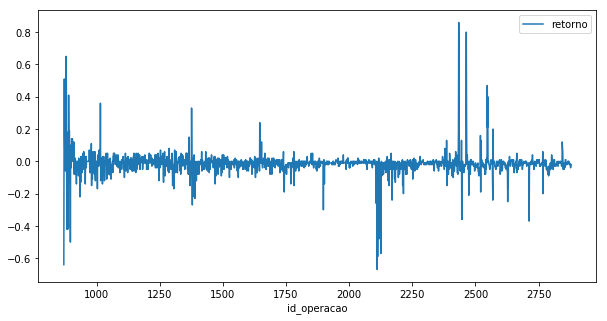

In [112]:
plt.figure()
resultado_operacoes[resultado_operacoes.type == 'buy'].plot(y='retorno',x='id_operacao',figsize=(10,5))

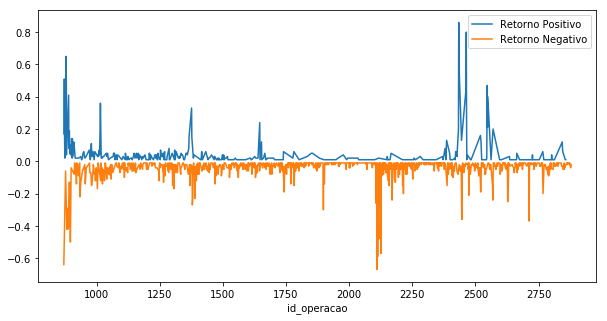

In [113]:
fig, ax = plt.subplots(figsize=(10,5))
op_ganho = resultado_operacoes[(resultado_operacoes.type == 'buy') & (resultado_operacoes.retorno > 0)]
op_perda = resultado_operacoes[(resultado_operacoes.type == 'buy') & (resultado_operacoes.retorno < 0)]

op_ganho.plot(y='retorno',x='id_operacao', label= 'Retorno Positivo', figsize=(10,5), ax= ax)
op_perda.plot(y='retorno',x='id_operacao', label= 'Retorno Negativo',figsize=(10,5), ax= ax)

0.86


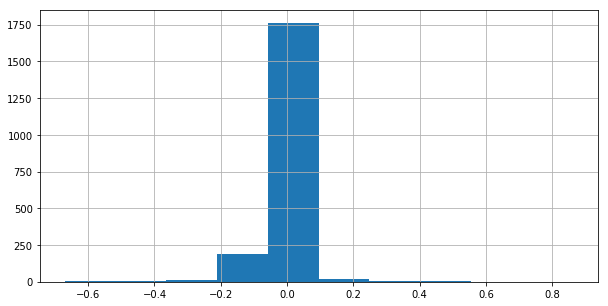

In [114]:
print(resultado_operacoes[resultado_operacoes.type == 'buy'].retorno.max())
resultado_operacoes[resultado_operacoes.type == 'buy'].retorno.hist(figsize=(10,5))

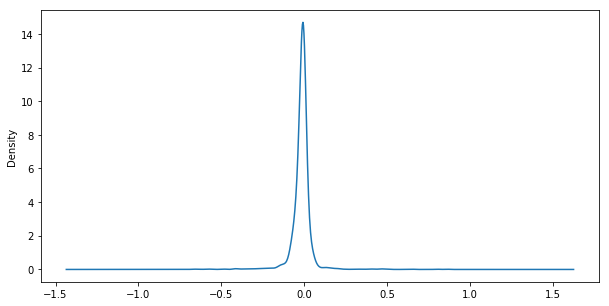

In [115]:
resultado_operacoes[resultado_operacoes.type == 'buy'].retorno.plot(kind='kde' , figsize=(10,5))

In [116]:
resultado_operacoes = []

for coin in dt_operacoes.coin.unique():
    
    investindo_100 = 100
    investindo_1000 = 1000
    investindo_10000 = 10000

    for id_op in dt_operacoes[dt_operacoes.coin == coin].id_operacao.unique():
        op = dt_operacoes[dt_operacoes.id_operacao == id_op]
        op_buy = op[op.type == 'buy'].max()
        op_sell = op[op.type == 'sell'].max()
        
        #RETORNO
        x = (op_sell.rate - op_buy.rate)
        simple_return = np.divide(x, op_buy.rate)    
        op_buy['retorno'] = round(simple_return,2)
        op_sell['retorno'] = round(simple_return,2)
            
        #Projeção R$100
        investindo_100 = investindo_100 + (investindo_100 * simple_return)
        op_buy['RS100'] = investindo_100
        op_sell['RS100'] = investindo_100
        
        #Projeção R$1000
        investindo_1000 = investindo_1000 + (investindo_1000 * simple_return)
        op_buy['RS1000'] = investindo_1000
        op_sell['RS1000'] = investindo_1000
        
        #Projeção R$10000
        investindo_10000 = investindo_10000 + (investindo_10000 * simple_return)
        op_buy['RS10000'] = investindo_10000
        op_sell['RS10000'] = investindo_10000
        
        #print(investindo_100)
            
        resultado_operacoes.append(op_buy)
        resultado_operacoes.append(op_sell)

In [117]:
resultado_operacoes = pd.DataFrame(resultado_operacoes)
resultado_operacoes.head(100)

,amount,globalTradeID,rate,total,tradeID,type,coin,day,id_operacao,closed,stop_update,stop,retorno,RS100,RS1000,RS10000
0,15.000000,9398983,1.850000,26.250000,13,buy,USDT_ETH,2015-08-08 07:26:52,870,True,1.0,1.954333,-0.64,35.675676,356.756762,3567.567622
1,0.111818,9484321,0.660000,0.073800,26,sell,USDT_ETH,2015-08-11 02:28:43,870,True,NaN,NaN,-0.64,35.675676,356.756762,3567.567622
2,0.111818,9484321,0.660000,0.073800,26,buy,USDT_ETH,2015-08-11 02:28:43,871,True,2.0,0.846999,0.17,41.621579,416.215795,4162.157946
3,0.019860,9497025,0.769999,0.015293,29,sell,USDT_ETH,2015-08-11 15:32:14,871,True,NaN,NaN,0.17,41.621579,416.215795,4162.157946
4,55.000000,9497028,0.770000,42.349958,32,buy,USDT_ETH,2015-08-11 15:32:14,872,True,3.0,1.210000,0.51,62.702304,627.023038,6270.230378
5,1.869916,9524757,1.159994,2.169091,56,sell,USDT_ETH,2015-08-12 11:57:42,872,True,NaN,NaN,0.51,62.702304,627.023038,6270.230378
6,78.055161,9503519,1.000000,78.055161,35,buy,USDT_ETH,2015-08-11 19:48:09,873,True,2.0,1.210000,0.16,72.734284,727.342843,7273.428425
7,1.869916,9524757,1.159994,2.169091,56,sell,USDT_ETH,2015-08-12 11:57:42,873,True,NaN,NaN,0.16,72.734284,727.342843,7273.428425
8,30.000000,9506185,1.140000,31.800000,40,buy,USDT_ETH,2015-08-11 21:05:00,874,True,1.0,1.210000,0.02,74.009929,740.099294,7400.992939
9,1.869916,9524757,1.159994,2.169091,56,sell,USDT_ETH,2015-08-12 11:57:42,874,True,NaN,NaN,0.02,74.009929,740.099294,7400.992939


In [118]:
for coin in resultado_operacoes.coin.unique():
    result_coin =  resultado_operacoes[resultado_operacoes.coin == coin]
    ultima_operacao = result_coin[result_coin.id_operacao == result_coin.id_operacao.max()].max()
    
    print('COIN: ',coin)
    print('Máximo retorno:', result_coin.retorno.max())
    print('Mínimo retorno:', result_coin.retorno.min())
    print('Retorno médio:', result_coin.retorno.mean())
    print('')
    print('Resultado investindo R$100:', ultima_operacao.RS100)
    print('Resultado investindo R$1.000:', ultima_operacao.RS1000)
    print('Resultado investindo R$10.000:', ultima_operacao.RS10000)
    print('')
    print('Quantidade de operações realizadas:', result_coin[result_coin.RS100 >= 0].id_operacao.count()/2)
    print('Quantidade de operações possíveis', result_coin.id_operacao.count()/2)
    print('')
    print('Quantidade de operações positivas:', result_coin[result_coin.retorno > 0].id_operacao.count()/2)
    print('Quantidade de operações negativas:', result_coin[result_coin.retorno < 0].id_operacao.count()/2)
    print('--------------------------------------------------------------------')
    print('')

COIN:  USDT_ETH
Máximo retorno: 0.8
Mínimo retorno: -0.64
Retorno médio: -0.013027027027

Resultado investindo R$100: 4.477144500643021e-05
Resultado investindo R$1.000: 0.0004477144500643022
Resultado investindo R$10.000: 0.004477144500643017

Quantidade de operações realizadas: 925.0
Quantidade de operações possíveis 925.0

Quantidade de operações positivas: 187.0
Quantidade de operações negativas: 566.0
--------------------------------------------------------------------

COIN:  USDT_LTC
Máximo retorno: 0.86
Mínimo retorno: -0.5
Retorno médio: -0.0106166868198

Resultado investindo R$100: 0.004102226376027371
Resultado investindo R$1.000: 0.04102226376027373
Resultado investindo R$10.000: 0.41022263760273686

Quantidade de operações realizadas: 827.0
Quantidade de operações possíveis 827.0

Quantidade de operações positivas: 136.0
Quantidade de operações negativas: 459.0
--------------------------------------------------------------------

COIN:  USDT_ZEC
Máximo retorno: 0.61
Mínimo